# Benchmark All Tasks

Let's benchmark against all tool usage tasks. 

Expand the `test` list to benchmark with different models and agent architectures.

Note that this requires `langsmith>=0.0.72` to run the viz parts at the end.

## Set Up


### Credentials

First, let's set up the models to be tested and the credentials.

In [ ]:
import os
from getpass import getpass

# This is just the default list below
required_env_vars = [
    "LANGCHAIN_API_KEY",
    "ANTHROPIC_API_KEY",
    "OPENAI_API_KEY",
]
for var in required_env_vars:
    if var not in os.environ:
        os.environ[var] = getpass(f"Provide the required {var}")

### Instantiate Models

In [2]:
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

from langchain_benchmarks.tool_usage.agents import StandardAgentFactory

tests = [
    (
        "claude-3-opus-20240229",
        ChatAnthropic(model="claude-3-opus-20240229", temperature=0),
    ),
    (
        "claude-3-haiku-20240307",
        ChatAnthropic(model="claude-3-haiku-20240307", temperature=0),
    ),
    (
        "claude-3-sonnet-20240229",
        ChatAnthropic(model="claude-3-sonnet-20240229", temperature=0),
    ),
    ("gpt-3.5-turbo-0125", ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)),
    (
        "gpt-4-turbo-2024-04-09",
        ChatOpenAI(model="gpt-4-turbo-2024-04-09", temperature=0),
    ),
]

### Set up the experiment

In [3]:
import datetime
import warnings

warnings.filterwarnings("ignore")

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langsmith.client import Client

from langchain_benchmarks import (
    __version__,
    clone_public_dataset,
    model_registry,
    registry,
)
from langchain_benchmarks.rate_limiting import RateLimiter

In [5]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "{instructions}"),  # Populated from task.instructions automatically
        ("human", "{input}"),  # Populated from the test dataset by each example
        MessagesPlaceholder("agent_scratchpad"),  # Workspace for the agent
    ]
)

Let's make an experiment id

In [7]:
experiment_uuid = "sky1"  # Or generate ranom using uuid.uuid4().hex[:4]
# experiment_uuid = uuid.uuid4().hex[:4]

Define the test cases

## Run

In [ ]:
client = Client()  # Launch langsmith client for cloning datasets
today = datetime.date.today().isoformat()

for task in registry.tasks:
    if task.type != "ToolUsageTask":
        continue

    if task.name == "Multiverse Math (Tiny)":
        continue

    dataset_name = task.name + f" ({today})"
    clone_public_dataset(task.dataset_id, dataset_name=dataset_name)

    for model_name, model in tests:
        print()
        print(f"Benchmarking {task.name} with model: {model_name}")
        eval_config = task.get_eval_config()
        rate_limiter = RateLimiter(requests_per_second=1)
        agent_factory = StandardAgentFactory(
            task, model, prompt, rate_limiter=rate_limiter
        )

        client.run_on_dataset(
            dataset_name=dataset_name,
            llm_or_chain_factory=agent_factory,
            evaluation=eval_config,
            verbose=False,
            project_name=f"{model_name}-{task.name}-{today}-{experiment_uuid}",
            concurrency_level=5,
            project_metadata={
                "model": model_name,
                "id": experiment_uuid,
                "task": task.name,
                "date": today,
                "langchain_benchmarks_version": __version__,
            },
        )

## Inspect

Note that if the queue is under significant load, you may want to wait before running the following to ensure all runs are in the DB and all stats are correctly computed.

In [14]:
!pip install --quiet -U pandas

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from langsmith.client import Client

Let's fetch all the data that has the same experiment ID and place it in a dataframe.

In [17]:
experiment_ids = ["sky1"]
dataset_names = [task.name for task in registry.filter(Type="ToolUsageTask")]

client = Client()
projects = []
for dataset_name in dataset_names:
    dataset_name_ = dataset_name + f" ({today})"
    for project in client.list_projects(reference_dataset_name=dataset_name_):
        if (
            project.metadata.get("id") in experiment_ids
            and project.end_time is not None
        ):
            projects.append(project)

dfs = []
keys = set()
for project in projects:
    # Temporary way to get tag information
    try:
        test_results = client.get_test_results(project_name=project.name)
    except Exception as e:
        print(e, project.run_count)
        continue

    for k, v in project.metadata.items():
        test_results[k] = v
    keys.update(test_results.columns)
    dfs.append(test_results)
for df in dfs:
    missing = list(keys - set(df.columns))
    for key in missing:
        df[key] = None
df = pd.concat(dfs)

Compute a standardized "correct" column. It uses "Correct Final State" for tool usage tasks, and "correctness (which is based on output) for the other tasks.

In [22]:
correct = []

for r in df.to_dict(orient="records"):
    if "Typewriter" in r["task"]:
        correct.append(r["feedback.correct final state"])
    else:
        correct.append(r["feedback.correctness"])

df["correct"] = correct
df["correct"].fillna(0, inplace=True)

Compute some statistics. We're using estimating standard error of the mean assuming a bernoulli process.

In [26]:
num_correct = df.groupby(["model", "task"])["correct"].sum().to_frame("num_correct")
total = df.groupby(["task", "model"]).size().to_frame("total")
stats_df = total.join(num_correct)
stats_df["% correct"] = stats_df["num_correct"] / stats_df["total"]
stats_df["error"] = np.sqrt(
    stats_df["% correct"] * (1 - stats_df["% correct"]) / stats_df["total"]
)

tasks = [
    "Tool Usage - Typewriter (1 tool)",
    "Tool Usage - Typewriter (26 tools)",
    "Multiverse Math",
    "Tool Usage - Relational Data",
]

stats_df = stats_df.reset_index()
models = stats_df["model"].unique()

In [41]:
models = [
    "claude-3-haiku-20240307",
    "claude-3-sonnet-20240229",
    "claude-3-opus-20240229",
    "gpt-3.5-turbo-0125",
    "gpt-4-turbo-2024-04-09",
]

Plot the result

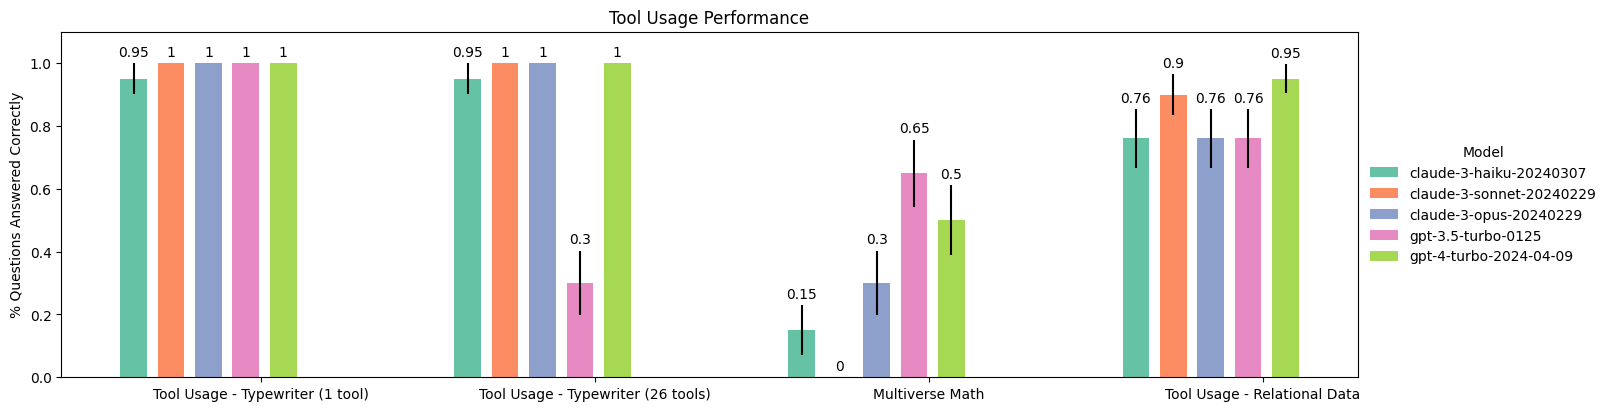

In [42]:
from itertools import product

x = np.arange(len(tasks))  # the label locations
width = 0.08  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout="constrained", figsize=(16, 4))
colormap = plt.get_cmap("Set2").colors
idx = 0
for model in models:
    try:
        results = stats_df.set_index("model").loc[model]
    except:
        continue
    if len(results) == 0:
        continue
    color = colormap[idx]
    idx += 1

    results = results.set_index("task").loc[tasks]
    measurement = results["% correct"]

    values = [round(m, 2) for m in measurement]

    offset = width * multiplier * 1.4
    rects = ax.bar(
        x + offset,
        values,
        width,
        label=f"{model}",
        yerr=results["error"],
        color=color,
    )
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("% Questions Answered Correctly")
ax.set_title("Tool Usage Performance")
ax.set_xticks(x + width + 0.3, tasks)
ax.legend(
    loc="center left", ncols=1, bbox_to_anchor=(1.0, 0.5), frameon=False, title="Model"
)
ax.set_ylim(0, 1.10)
plt.savefig("overall_perf.png", dpi=300, bbox_inches="tight")
plt.show()